In [129]:
import numpy as np 
from gcs import path_handler as ph 
import gcs
import tstrippy
import matplotlib.pyplot as plt
import os 
import h5py

In [130]:
def snag_all_init_cond_per_GC(fname, nmontecarlo=50):
    with h5py.File(fname, "r") as myfile:
        x = np.zeros(nmontecarlo)
        y = np.zeros(nmontecarlo)
        z = np.zeros(nmontecarlo)
        vx = np.zeros(nmontecarlo)
        vy = np.zeros(nmontecarlo)
        vz = np.zeros(nmontecarlo)
        
        for j in range(nmontecarlo):
            group = myfile[f"monte-carlo-{str(j).zfill(3)}"]
            x[j] = group['xt'][0]
            y[j] = group['yt'][0]
            z[j] = group['zt'][0]
            vx[j] = group['vxt'][0]
            vy[j] = group['vyt'][0]
            vz[j] = group['vzt'][0]
        
        return x, y, z, vx, vy, vz

In [131]:
def allensantillianhalo(params,x,y,z):
    G = params[0]
    M= params[1]
    a = params[2]
    gamma = params[3]
    rcut = params[4]

    r = np.sqrt(x**2+y**2+z**2)
    beyond = r>rcut

    massMod = M*(r/a)**gamma
    massMod = massMod/(1+(r/a)**(gamma-1))
    amod = G*massMod/r**3
    ax,ay,az = -amod*x,-amod*y,-amod*z

    # update for the case where r>rcut
    mtotal = M*(rcut/a)**gamma / (1+(rcut/a)**(gamma-1))
    amod = G*mtotal/rcut**3
    ax[beyond],ay[beyond],az[beyond] = -amod*x[beyond],-amod*y[beyond],-amod*z[beyond]

    phic = -(G*mtotal/rcut) - (G*M/a) * np.log(1 + (rcut/a)**(gamma-1))
    phi = (G*M/a) * np.log(1 + (r/a)**(gamma-1)) +phic

    phi[beyond] =  -(G*mtotal/r[beyond]) 

    return ax,ay,az,phi


def correctedhalo(MWparams,x,y,z):
    haloparms = [*MWparams[0:5]]
    disk1params = [MWparams[0],*MWparams[5:8]]
    disk2params = [MWparams[0],*MWparams[8:]]
    phi = allensantillianhalo(haloparms,x,y,z)[3]
    phi1 = tstrippy.potentials.miyamotonagai(disk1params,x,y,z)[3]
    phi2 = tstrippy.potentials.miyamotonagai(disk2params,x,y,z)[3]
    return phi+phi1+phi2



In [132]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [133]:
dark=False
potential="pouliasis2017pii"
montecarlokey="monte-carlo-000"
results_path=ph.paths['simulations'] + "/ImpactGeometry/pouliasis2017pii-GCNBody/Pal5"+"/AllImpactGeometryByHandAndEye.csv"

In [134]:
if dark==True:
    plt.style.use('dark_background')
    outname="E_Lz_perturbers_dark.png"
    outname2="Pal5_radial_coordinate_with_perturbers_dark.png"
    outname3="mass_size_plane_dark.png"
else:
    outname="E_Lz_perturbers.png"
    outname2="Pal5_radial_coordinate_with_perturbers.png"
    outname3="mass_size_plane.png"



In [135]:
# Assuming the CSV file has a header
data = np.genfromtxt(results_path, delimiter=',', names=True, dtype=None, encoding='utf-8')

# Extract each column into a separate numpy array
column_names = data.dtype.names
columns = {name: data[name] for name in column_names}
# Example: Accessing individual columns
impact_parameter = columns['impact_parameter']
gap_flag = columns['gap_flag']
suspects=columns['suspect']
montecarlokey = columns["montecarlokey"]
Mass=columns['Mass']
rplum=columns['rplum']
guilty=np.unique(suspects[gap_flag])
tau=columns['tau']
Time=columns['T']

In [136]:
GCnames=tstrippy.Parsers.baumgardtMWGCs().data['Cluster']

In [137]:
guilty = suspects[gap_flag]
guilty_montecarlokey = montecarlokey[gap_flag]
guilty_impact_parameter = impact_parameter[gap_flag]
guilty_mass = Mass[gap_flag]
guilty_rplum = rplum[gap_flag]
guilty_tau = tau[gap_flag]
guilty_time = Time[gap_flag]

In [138]:
# get the ids of those that were guilty
guilty_ids =[]
for i in range(len(guilty)):
    guilty_ids.append( [np.where(GCnames==guilty[i])[0][0],int(guilty_montecarlokey[i].split("-")[2])])
pal5ID = np.where(GCnames=="Pal5")[0][0]

In [139]:
import datetime
import numpy as np
from multiprocessing import Pool

MWparams = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
nmontecarlo = 50
phase_space = np.zeros((len(GCnames), 6))
V = np.zeros((len(GCnames), nmontecarlo))
T = np.zeros((len(GCnames), nmontecarlo))
Lz = np.zeros((len(GCnames), nmontecarlo))

def compute_gc_properties(i):
    x, y, z, vx, vy, vz = snag_all_init_cond_per_GC(ph.GC_orbits(potential, GCnames[i]))
    phi = correctedhalo(MWparams, x, y, z)
    T = 0.5 * (vx**2 + vy**2 + vz**2)
    Lz = x * vy - y * vx
    return i, phi, T, Lz

starttime = datetime.datetime.now()

# Create a pool of worker processes
with Pool() as pool:
    results = pool.map(compute_gc_properties, range(len(GCnames)))

# Collect the results
for i, phi, T_val, Lz_val in results:
    V[i] = phi
    T[i] = T_val
    Lz[i] = Lz_val

endtime = datetime.datetime.now()
print("total compute time:", endtime - starttime, "s")

total compute time: 0:00:00.728684 s


In [141]:
E = T.flatten() + V.flatten()
Lzz=Lz.flatten()

In [142]:
num_objects=len(GCnames)
# Get a colormap
cmap = plt.get_cmap('cividis')
# Generate a list of unique colors
colors = [cmap(i / num_objects) for i in range(num_objects)]
# Define a list of marker styles
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'd',]


In [143]:
AXIS=dict(xlabel=r"$L_z$ [kpc km/s]",
          ylabel=r"$E$ [km$^2$/s$^2$]",
          xlim=[-5000,5000])

In [144]:
import matplotlib.cm as cm
unique_suspects = np.unique(guilty)
cmap = cm.get_cmap('tab20', len(unique_suspects))  # 'tab20' is a colormap with 20 distinct colors
perturbercolors = {unique_suspects[i]: cmap(i) for i in range(len(unique_suspects))}


/tmp/ipykernel_128336/718634135.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(unique_suspects))  # 'tab20' is a colormap with 20 distinct colors


In [145]:
perturberscatter={"facecolors":"red","edgecolors":"white","alpha":0.8}


/tmp/ipykernel_128336/2930043440.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Lz[*myids],T[*myids]+V[*myids],c=perturbercolors[GCnames[myids[0]]],alpha=1)


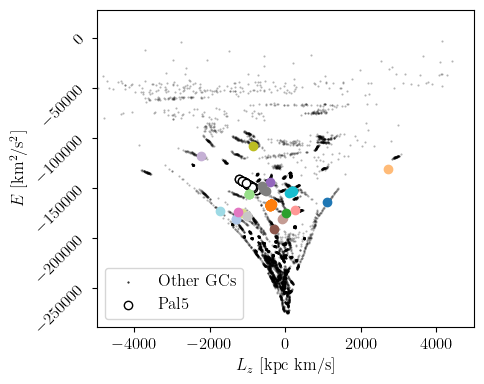

In [151]:
outdir="../paper/"
outname="E_Lz_perturbers.png"
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.scatter(Lz[i][:],T[i]+V[i],color="k",s=1,alpha=1,marker=".",label="Other GCs")
for i in range(1,num_objects):
    marker = markers[i % len(markers)]  # Cycle through markers
    ax.scatter(Lz[i][:],T[i]+V[i],color="k",s=1,alpha=0.3,marker=".")

ax.scatter(Lz[pal5ID][:],T[pal5ID][:]+V[pal5ID][:],label="Pal5",facecolors='white',edgecolors='black')

# ax.scatter(Lz[*guilty_ids[0]],T[*guilty_ids[0]]+V[*guilty_ids[0]],label="Perturbers",*perturberscatter)
for myids in guilty_ids:
    ax.scatter(Lz[*myids],T[*myids]+V[*myids],c=perturbercolors[GCnames[myids[0]]],alpha=1)

# for j in range(1,len(guilty_ids)):
    # ax.scatter(Lz[*guilty_ids[j]],T[*guilty_ids[j]]+V[*guilty_ids[j]],**perturberscatter)


ax.set(**AXIS)
ax.tick_params(axis='y', rotation=45)  # Rotate y-axis ticks by 45 degrees
ax.legend(fontsize=12)

fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)

# Mass and Size

In [152]:
Mass_all=tstrippy.Parsers.baumgardtMWGCs().data['Mass']
rh_m=tstrippy.Parsers.baumgardtMWGCs().data['rh_m']
DM=tstrippy.Parsers.baumgardtMWGCs().data['DM']

In [153]:
from matplotlib.patches import Ellipse

In [154]:
rplum_all=gcs.misc.half_mass_to_plummer(rh_m.value)

In [155]:
guilty_rh_m=[]
for xx in guilty_ids:
    guilty_rh_m.append(rh_m[xx[0]].value)
guilty_rh_m=np.array(guilty_rh_m)

In [156]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

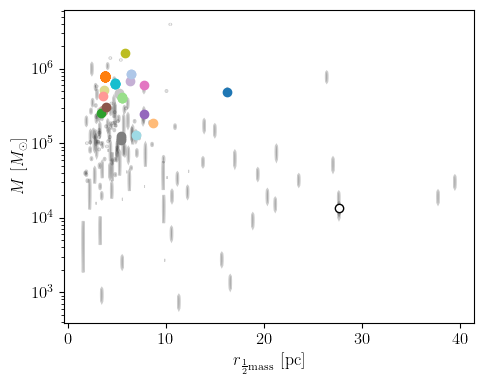

In [158]:
AXIS=dict(yscale='log',xlabel=r"$r_{\rm \frac{1}{2} mass}$ [pc]",ylabel=r"$M$ [$M_{\odot}$]")


fig,myaxis=plt.subplots(1,1,figsize=(5,4))
for i in range(len(Mass_all)):
    xy=(1000*rh_m[i].value,Mass_all[i].value,2*DM[i].value)
    # print(xy)
    ellipse = Ellipse(xy=(1000*rh_m[i].value,Mass_all[i].value), width=.1, height=2*DM[i].value, lw=2,color="k",alpha=0.2)
    myaxis.add_patch(ellipse)


for i in range(len(guilty_ids)):
    myaxis.scatter(1000*guilty_rh_m[i],guilty_mass[i],marker='o',facecolor=perturbercolors[GCnames[guilty_ids[i][0]]],linestyle='None',label="Perturbers",zorder=1,alpha=1)
# myaxis.scatter(1000*guilty_rh_m,guilty_mass,marker='o',facecolor='red',linestyle='None',label="Other GCs",edgecolor='white',zorder=0,alpha=0.8)

# axis.scatter(1000*rh_m.value,Mass,label="Perturbers",)
myaxis.scatter(1000*rh_m[pal5ID].value,Mass_all[pal5ID],label="Pal5",facecolor='white',edgecolor='black',zorder=1)
myaxis.set(**AXIS)


# axis.legend()
fig.tight_layout()
fig.savefig(outdir+outname3,dpi=300)
plt.show()

# $$\rho = \log(N) $$

# $$ \delta \rho = \frac{d \rho}{dN} \delta N$$

# $$ \delta \rho = \frac{1}{\ln (10) (N)} \sqrt{N} $$

# $$ \delta \rho = \frac{1}{\ln(10) \sqrt{N}}  $$

# impongo che 
## $$ S/R = 50 $$

# $$ 50 >  \log(N) \ln(10) \sqrt{N} $$



# Where does this happen on the orbit?

In [159]:
# Assuming the CSV file has a header
data = np.genfromtxt(results_path, delimiter=',', names=True, dtype=None, encoding='utf-8')

# Extract each column into a separate numpy array
column_names = data.dtype.names
columns = {name: data[name] for name in column_names}
# Example: Accessing individual columns
impact_parameter = columns['impact_parameter']
gap_flag = columns['gap_flag']
suspects=columns['suspect']
montecarlokey = columns["montecarlokey"]
Mass=columns['Mass']
rplum=columns['rplum']
guilty=suspects[gap_flag]
tau=columns['tau']
Time=columns['T']

In [160]:
montecarlokeys=montecarlokey[gap_flag]
taus=tau[gap_flag]
times=Time[gap_flag]
mysuspects=suspects[gap_flag]

In [161]:
Rs,zs=[],[]
myMinR,myMaxR=100,0


i=0
for i in range(len(taus)):
    t,x,y,z,vx,vy,vz=gcs.extractors.GCOrbits.extract_whole_orbit(ph.GC_orbits(potential,"Pal5"),montecarlokey=montecarlokeys[i])
    myRs = np.sqrt(x**2+y**2)
    if np.min(myRs)<myMinR:
        myMinR=np.min(myRs)
        minindex=i
    if np.max(myRs)>myMaxR:
        myMaxR=np.max(myRs)
        maxindex=i
    index = np.argmin(np.abs(t-(times[i]+taus[i])))
    Rs.append(np.sqrt(x[index]**2+y[index]**2))
    zs.append(z[index])
R = np.sqrt(x**2+y**2)

In [162]:
minindex,maxindex
print(montecarlokeys[minindex],montecarlokeys[maxindex])

monte-carlo-008 monte-carlo-026


In [163]:
# stack all Rs and zs for pal 5

In [164]:
sizeT=50000
RsPal = np.zeros(sizeT*nmontecarlo)
zsPal = np.zeros(sizeT*nmontecarlo)
for i in range(nmontecarlo):
    t0,x0,y0,z0,vx0,vy0,vz0=gcs.extractors.GCOrbits.extract_whole_orbit(ph.GC_orbits(potential,"Pal5"),montecarlokey="monte-carlo-"+str(i).zfill(3))
    RsPal[i*sizeT:(i+1)*sizeT]=np.sqrt(x0[0:sizeT]**2+y0[0:sizeT]**2)
    zsPal[i*sizeT:(i+1)*sizeT]=z0[0:sizeT]



In [165]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [166]:
zmax = np.abs(zsPal).max()
zlims=[-zmax,zmax]
Rlims=[0,myMaxR]

In [167]:
np.sqrt(nmontecarlo*sizeT)

1581.1388300841897

In [168]:
def gaussian_kernel(size, sigma=1):
    """Generate a Gaussian kernel."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)
def convolve2d(image, kernel):
    """Perform a 2D convolution."""
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Pad the image with zeros on all sides
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Initialize the output array
    output = np.zeros_like(image)

    # Perform the convolution
    for i in range(image_height):
        for j in range(image_width):
            output[i, j] = np.sum(padded_image[i:i+kernel_height, j:j+kernel_width] * kernel)

    return output

In [169]:
nbins = int(np.ceil(np.sqrt(nmontecarlo*sizeT)))
Redges=np.linspace(Rlims[0],Rlims[1],nbins)
zedges = np.linspace(zlims[0], zlims[1], nbins)
hist, xedges, yedges = np.histogram2d(RsPal, zsPal, bins=(Redges, zedges))


In [170]:
binsize = xedges[1] - xedges[0]
physical_size = 0.2
kernel_size=int(physical_size/binsize)
sigma = 3.0


In [171]:
my_gaussian_kernel = gaussian_kernel(kernel_size, sigma)
print(gaussian_kernel)
smoothed_hist = convolve2d(hist, my_gaussian_kernel)


<function gaussian_kernel at 0x7fc181e40680>


In [173]:
smoothed_hist_normed = smoothed_hist / smoothed_hist.max()

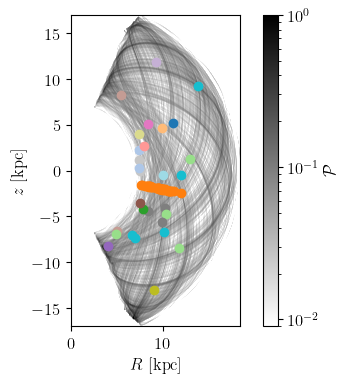

In [175]:
outname = "impact_stats_phase_space.png"
from matplotlib import colors
fig,axis=plt.subplots(1,1,figsize=(5,4))

for i in range(len(Rs)):
    axis.scatter(Rs[i],zs[i],zorder=1,facecolor=perturbercolors[guilty[i]])

im=axis.pcolorfast(Rlims, zlims, smoothed_hist_normed.T, cmap='gray_r',norm=colors.LogNorm(vmin=1,vmax=1e-2))
cbar=fig.colorbar(im, ax=axis,label=r"$\mathcal{P}$")
axis.set_xlim(Rlims)
axis.set_ylim(zlims)
axis.set(xlabel=r"$R$ [kpc]",ylabel=r"$z$ [kpc]")
axis.set_aspect('equal')
fig.tight_layout()
fig.savefig(outdir+outname,dpi=300)